# Honey Bee Health CNN
This notebook covers the construction and fitting of CNN models to predict the health of a honey bee based on it's image. Filepaths are configured such that the Capstone repo should be uploaded in its entirety to Google Drive.

### Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import compute_class_weight
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import utils
import tensorflow

#### Mount Google Drive
  - if forking and cloning from Github repo, upload entire Capstone folder to the default `~/MyDrive/` location in Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Global Variables

In [3]:
IMAGE_PATH = '/content/drive/MyDrive/Capstone/data/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
PATIENCE = 5
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50

In [4]:
# Test file retrieval from directory
os.listdir(IMAGE_PATH)[:10]

['039_005.png',
 '041_071.png',
 '041_075.png',
 '040_261.png',
 '041_014.png',
 '040_234.png',
 '038_304.png',
 '040_522.png',
 '037_021.png',
 '040_087.png']

### Read In Cleaned Data with Image Dimensions

In [5]:
bee_df = pd.read_csv('/content/drive/MyDrive/Capstone/data/bee_data_w_image.csv')

## Train-test-split

In [6]:
train_df, test_df = train_test_split(bee_df, test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE, 
                                     stratify=bee_df['health'])

train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, 
                                    random_state=RANDOM_STATE, 
                                    stratify=train_df['health'])

In [7]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [8]:
# Training Set Target Occurances
train_df['health'].value_counts(normalize=True)

healthy                       0.654276
few varrao, hive beetles      0.111816
Varroa, Small Hive Beetles    0.091266
ant problems                  0.088546
hive being robbed             0.048655
missing queen                 0.005440
Name: health, dtype: float64

In [9]:
# Validation Set Target Occurances
val_df['health'].value_counts(normalize=True)

healthy                       0.654589
few varrao, hive beetles      0.112319
Varroa, Small Hive Beetles    0.090580
ant problems                  0.088164
hive being robbed             0.048309
missing queen                 0.006039
Name: health, dtype: float64

In [10]:
# Testing Set Target Occurances
test_df['health'].value_counts(normalize=True)

healthy                       0.654106
few varrao, hive beetles      0.112077
Varroa, Small Hive Beetles    0.091787
ant problems                  0.087923
hive being robbed             0.048309
missing queen                 0.005797
Name: health, dtype: float64

## Imbalanced Classes

 - The data is highly imbalanced with respect to most frequent occuring value in our target, health. The number of healthy bees in our training set greatly outnumbers the other classes, by almost 6:1 at the lowest ratio.

 - To solve this, I will use the `compute_class_weight` function from `sklearn.utils`. This outputs an array of class weights, according to the class labels.

In [11]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_df.health), y = train_df.health)

In [12]:
class_int_labels = [i for i in range(0,len(class_weights))]

In [13]:
class_weights = dict(zip(class_int_labels, class_weights))

### Defining Functions For Reading Images and Data

The function below will read an image, resize it to 100x100 px, and return the pixel data from the image.

In [14]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

The function below will iterate through the list of files, and apply the image reading function, then stack all the image data from all files, and set X to equal the image data. It will also get dummy variables for the target, and return X and y.

In [15]:
def categories_encoder(dataset, var='health'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [16]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

## Baseline

In [17]:
bee_df.health.value_counts(normalize=True)

healthy                       0.654292
few varrao, hive beetles      0.111949
Varroa, Small Hive Beetles    0.091261
ant problems                  0.088360
hive being robbed             0.048531
missing queen                 0.005607
Name: health, dtype: float64

As this is a multi-class classification problem, we can consider our baseline accuracy to be the occurance of the majority class. In our case, this is the healthy status, with a 65.43% accuracy. Any improvement of the per-class accuracies and total accuracy will be considered an improvement.

## CNN

In order for our CNN to efficiently compute weights, the pixel data must be normalized to a minimum of 0 and a maximum of 1.

In [18]:
X_train.max(), X_val.max(), X_test.max()

(1.0, 1.0, 1.0)

In [19]:
X_train.min(), X_val.min(), X_test.min()

(0.0, 0.0, 0.0)

## Building The Model Architecture
 - The initial CNN is a sequential model, with two convolutional layers and 1 MaxPooling layer to reduce dimensionality. We use the Adam optimizer, compute the categorical crossentropy loss function, and measure accuracy.

 - When fitting, the dictionary created previously, `class_weights`, is passed to the parameter of `class_weight` to resolve imbalanced classes.

In [20]:
model1 = Sequential()


model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 6)                 240006    
                                                                 
Total params: 242,774
Trainable params: 242,774
Non-trainable params: 0
__________________________________________________

In [22]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    class_weight = class_weights,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 9s 100ms/step - loss: 1.9616 - accuracy: 0.2708 - val_loss: 1.3562 - val_accuracy: 0.5809
Epoch 2/10
13/13 [==============================] - 1s 48ms/step - loss: 1.2091 - accuracy: 0.5530 - val_loss: 1.3583 - val_accuracy: 0.5435
Epoch 3/10
13/13 [==============================] - 1s 49ms/step - loss: 0.8856 - accuracy: 0.6150 - val_loss: 1.0102 - val_accuracy: 0.6606
Epoch 4/10
13/13 [==============================] - 1s 53ms/step - loss: 0.7157 - accuracy: 0.6724 - val_loss: 0.8605 - val_accuracy: 0.6944
Epoch 5/10
13/13 [==============================] - 1s 48ms/step - loss: 0.5768 - accuracy: 0.7664 - val_loss: 0.7046 - val_accuracy: 0.7343
Epoch 6/10
13/13 [==============================] - 1s 47ms/step - loss: 0.4939 - accuracy: 0.7851 - val_loss: 0.5624 - val_accuracy: 0.7995
Epoch 7/10
13/13 [==============================] - 1s 48ms/step - loss: 0.4260 - accuracy: 0.8326 - val_loss: 0.5316 - val_accuracy: 0.8152
Epoch 8/10
1

### Plotting Accuracy and Loss

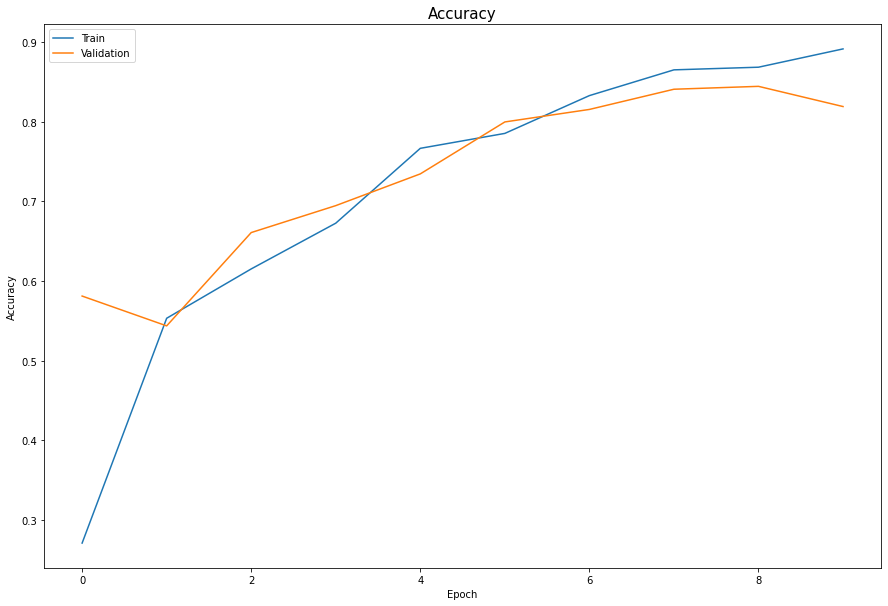

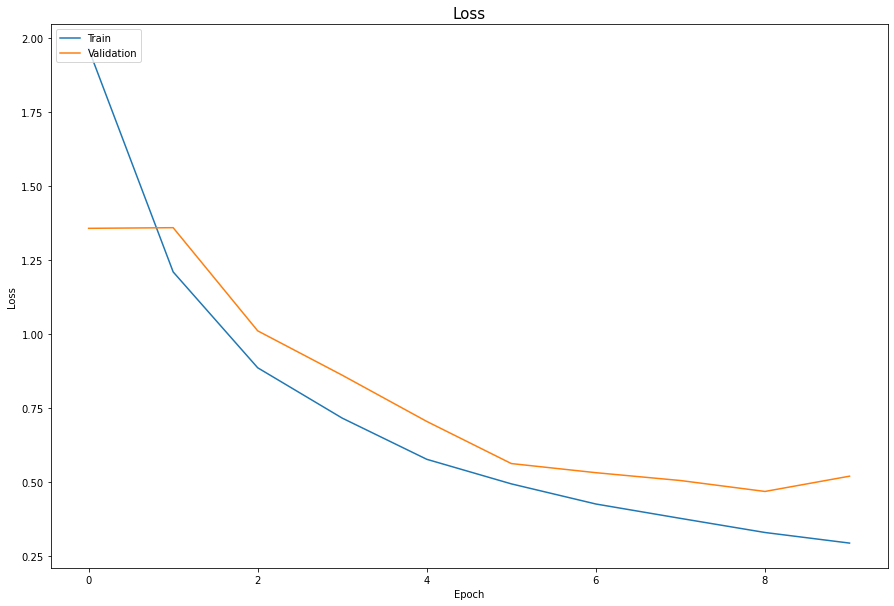

In [24]:
# summarize history for accuracy
def plot_acc_and_loss(model):
  plt.figure(figsize=(15,10))
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Accuracy', fontsize = 15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.figure(figsize=(15,10))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Loss', fontsize = 15)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

plot_acc_and_loss(history1)

### With Image Augmentation
 - `ImageDataGenerator` augments image data in real time and passes it through to the model to fit.
 - Augmentations include random width and height shifts, random zoom, random rotation, and horizontal and vertical flips.

In [25]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [28]:
model1_aug = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        class_weight = class_weights,
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


103/103 [==============================] - 8s 73ms/step - loss: 0.5148 - accuracy: 0.7667 - val_loss: 0.5614 - val_accuracy: 0.7911
Epoch 2/10
103/103 [==============================] - 7s 72ms/step - loss: 0.5306 - accuracy: 0.7543 - val_loss: 0.4363 - val_accuracy: 0.8104
Epoch 3/10
103/103 [==============================] - 7s 72ms/step - loss: 0.4402 - accuracy: 0.7752 - val_loss: 0.4413 - val_accuracy: 0.8116
Epoch 4/10
103/103 [==============================] - 7s 72ms/step - loss: 0.5240 - accuracy: 0.7588 - val_loss: 0.5095 - val_accuracy: 0.7971
Epoch 5/10
103/103 [==============================] - 7s 72ms/step - loss: 0.4246 - accuracy: 0.7851 - val_loss: 0.4082 - val_accuracy: 0.8225
Epoch 6/10
103/103 [==============================] - 7s 72ms/step - loss: 0.4412 - accuracy: 0.7872 - val_loss: 0.5825 - val_accuracy: 0.7415
Epoch 7/10
103/103 [==============================] - 8s 73ms/step - loss: 0.4296 - accuracy: 0.7942 - val_loss: 0.4268 - val_accuracy: 0.8200
Epoch 8/10

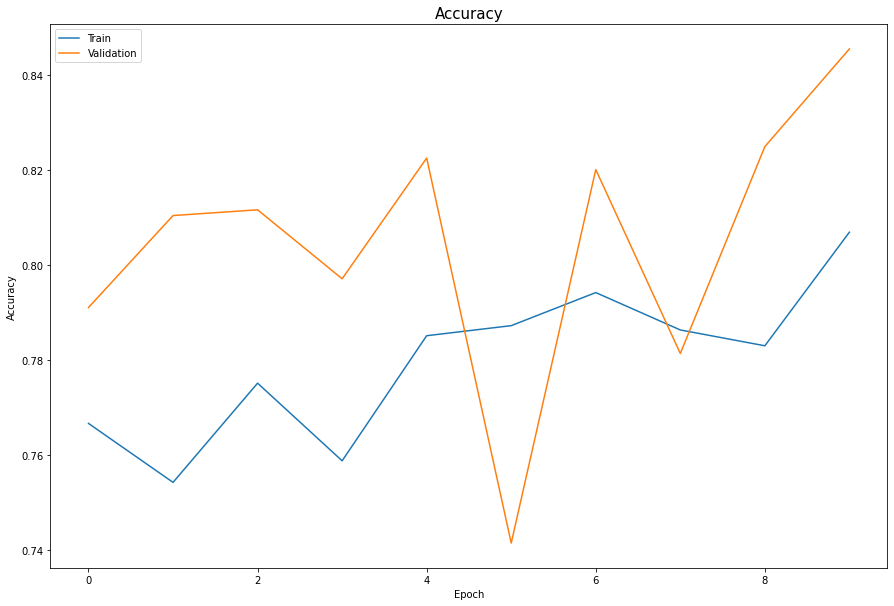

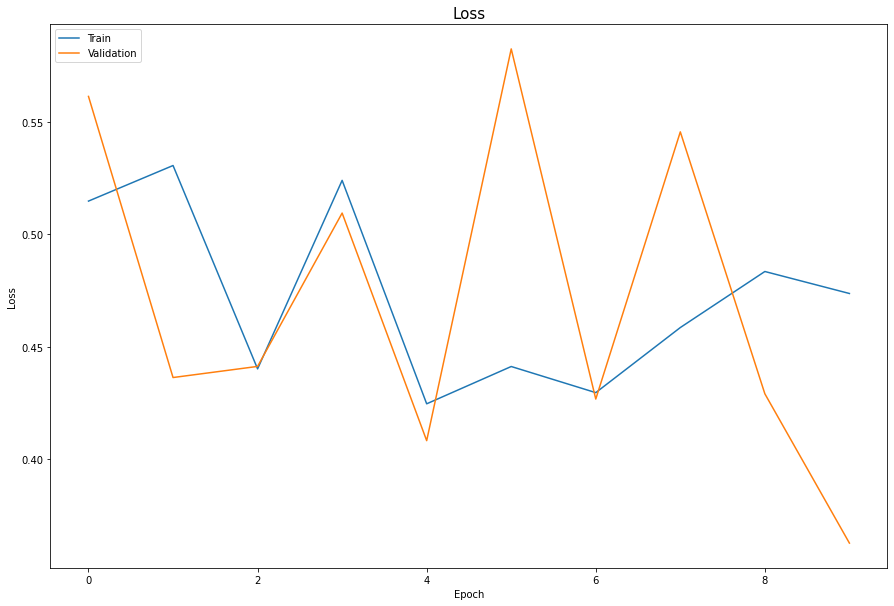

In [29]:
plot_acc_and_loss(model1_aug)

#### Model Evaluation

In [30]:
score = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 0s 7ms/step - loss: 0.3413 - accuracy: 0.8357
Test loss: 0.34132346510887146
Test accuracy: 0.8357487916946411


In [31]:
# A function to generate a classification report and print model evaluation metrics
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [32]:
test_accuracy_report(model1)

33/33 [==============================] - 0s 4ms/step
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.67      0.46      0.55        95
              ant problems       0.84      0.96      0.89        91
  few varrao, hive beetles       0.54      0.72      0.61       116
                   healthy       0.98      0.88      0.93       677
         hive being robbed       0.53      0.94      0.68        50
             missing queen       0.67      1.00      0.80         6

                  accuracy                           0.84      1035
                 macro avg       0.70      0.83      0.74      1035
              weighted avg       0.86      0.84      0.84      1035

Loss function: 0.34132346510887146, accuracy: 0.8357487916946411


### CNN with Dropout Layers

In [41]:
model_drop=Sequential()
model_drop.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_drop.add(MaxPool2D(MAX_POOL_DIM))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Flatten())
model_drop.add(Dense(y_train.columns.size, activation='softmax'))
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model_drop_aug  = model_drop.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        class_weight = class_weights,
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


103/103 [==============================] - 8s 75ms/step - loss: 1.7152 - accuracy: 0.4037 - val_loss: 1.4820 - val_accuracy: 0.1667
Epoch 2/10
103/103 [==============================] - 8s 75ms/step - loss: 1.2359 - accuracy: 0.5295 - val_loss: 1.2216 - val_accuracy: 0.5048
Epoch 3/10
103/103 [==============================] - 8s 74ms/step - loss: 0.9297 - accuracy: 0.5485 - val_loss: 1.1076 - val_accuracy: 0.5181
Epoch 4/10
103/103 [==============================] - 8s 73ms/step - loss: 0.8048 - accuracy: 0.5775 - val_loss: 1.1599 - val_accuracy: 0.4674
Epoch 5/10
103/103 [==============================] - 8s 73ms/step - loss: 0.6520 - accuracy: 0.6594 - val_loss: 0.6717 - val_accuracy: 0.7198
Epoch 6/10
103/103 [==============================] - 8s 73ms/step - loss: 0.6557 - accuracy: 0.6948 - val_loss: 0.8822 - val_accuracy: 0.6715
Epoch 7/10
103/103 [==============================] - 9s 86ms/step - loss: 0.6502 - accuracy: 0.7232 - val_loss: 0.7175 - val_accuracy: 0.7126
Epoch 8/10

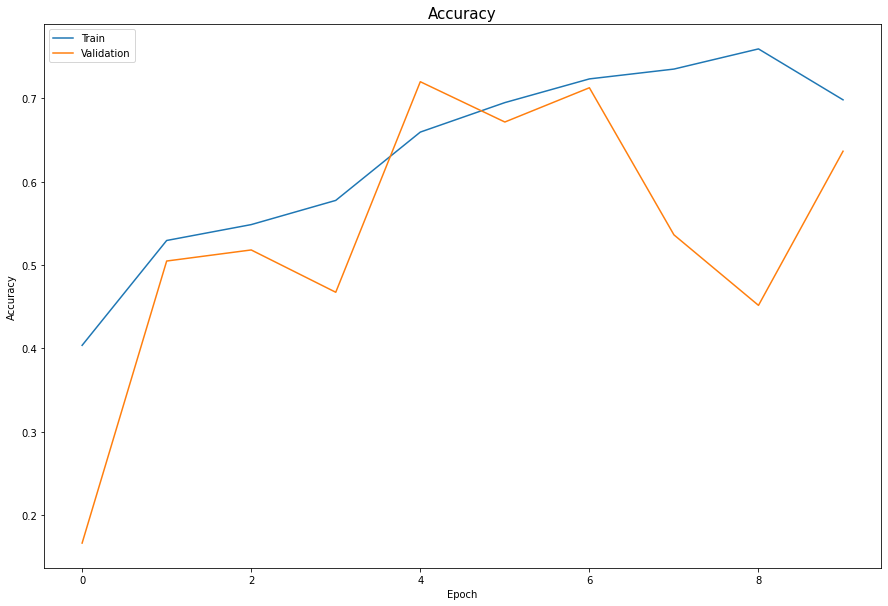

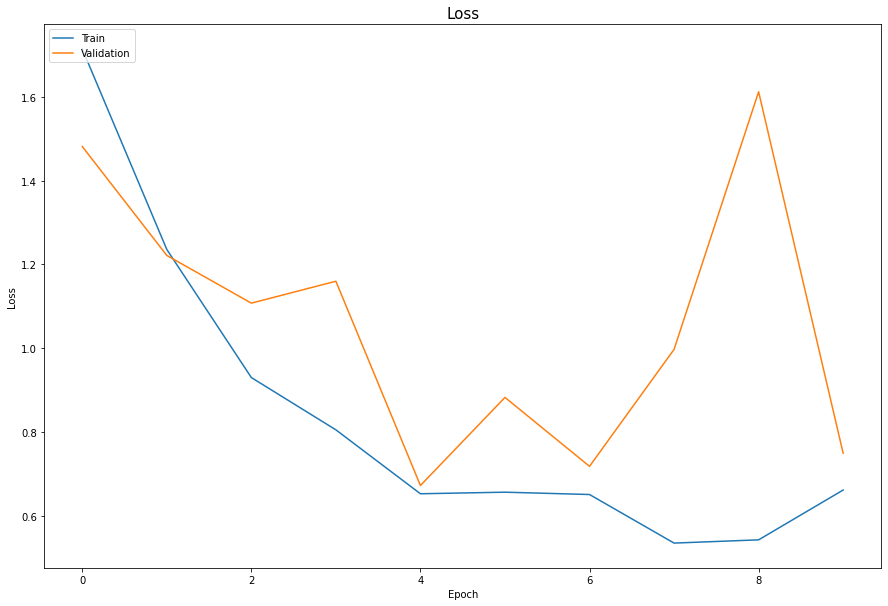

In [43]:
plot_acc_and_loss(model_drop_aug)

In [44]:
test_accuracy_report(model_drop)

33/33 [==============================] - 0s 4ms/step
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.43      0.55      0.48        95
              ant problems       0.76      0.96      0.85        91
  few varrao, hive beetles       0.43      0.42      0.43       116
                   healthy       0.96      0.60      0.74       677
         hive being robbed       0.17      0.88      0.29        50
             missing queen       0.75      1.00      0.86         6

                  accuracy                           0.63      1035
                 macro avg       0.58      0.73      0.61      1035
              weighted avg       0.79      0.63      0.67      1035

Loss function: 0.7275374531745911, accuracy: 0.6251207590103149


Our model has reduced it accuracy due to the dropout layers. We will retrain the model using more epochs, and incorporating changes to the learning rate.

### CNN with dropout layers and modified learning rate

 - The learning rate is the change in the model based on the error. Adjusting the learning rate as the model trains can result in greater accuracy by decreasing the learning rate progressively, which has the trade-off of potentially making the model take longer to converge.
 - An early stopping function is incorporated as well, to stop training when the model does not improve for more than 5 epochs.

In [45]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=1)

In [46]:
model_lr=Sequential()
model_lr.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_lr.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Flatten())
model_lr.add(Dense(y_train.columns.size, activation='softmax'))
model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
train_model_lr  = model_lr.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3*2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        class_weight = class_weights,
                        callbacks=[earlystopper, annealer])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


103/103 [==============================] - 8s 75ms/step - loss: 1.8427 - accuracy: 0.2668 - val_loss: 1.7731 - val_accuracy: 0.0399 - lr: 7.7831e-04
Epoch 2/100
103/103 [==============================] - 8s 73ms/step - loss: 1.5148 - accuracy: 0.4503 - val_loss: 1.4539 - val_accuracy: 0.4795 - lr: 7.7442e-04
Epoch 3/100
103/103 [==============================] - 8s 73ms/step - loss: 0.9365 - accuracy: 0.6283 - val_loss: 0.7028 - val_accuracy: 0.7089 - lr: 7.7055e-04
Epoch 4/100
103/103 [==============================] - 8s 73ms/step - loss: 0.8168 - accuracy: 0.6673 - val_loss: 0.8221 - val_accuracy: 0.7234 - lr: 7.6670e-04
Epoch 5/100
103/103 [==============================] - 8s 73ms/step - loss: 0.8298 - accuracy: 0.6558 - val_loss: 1.0194 - val_accuracy: 0.5870 - lr: 7.6286e-04
Epoch 6/100
103/103 [==============================] - 7s 72ms/step - loss: 0.7012 - accuracy: 0.6990 - val_loss: 0.6930 - val_accuracy: 0.7464 - lr: 7.5905e-04
Epoch 7/100
103/103 [=========================

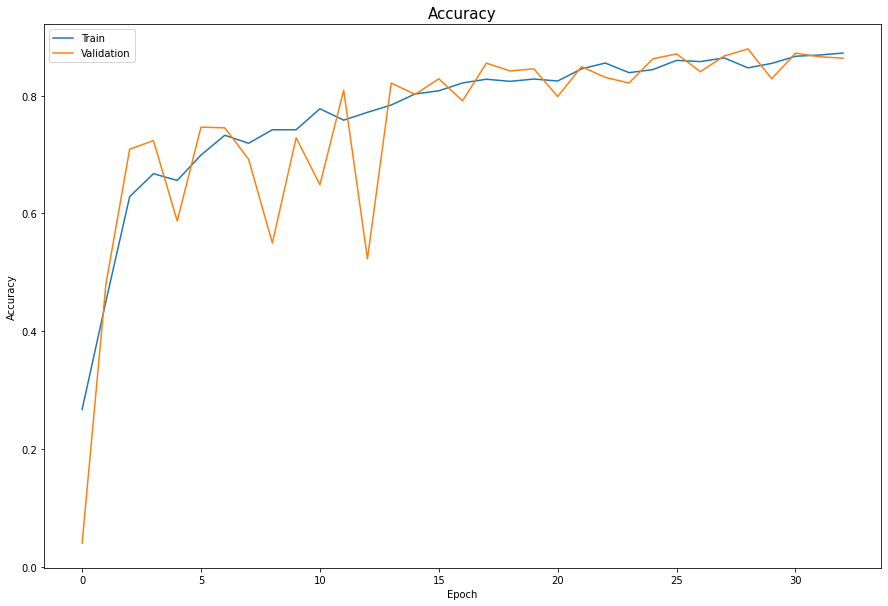

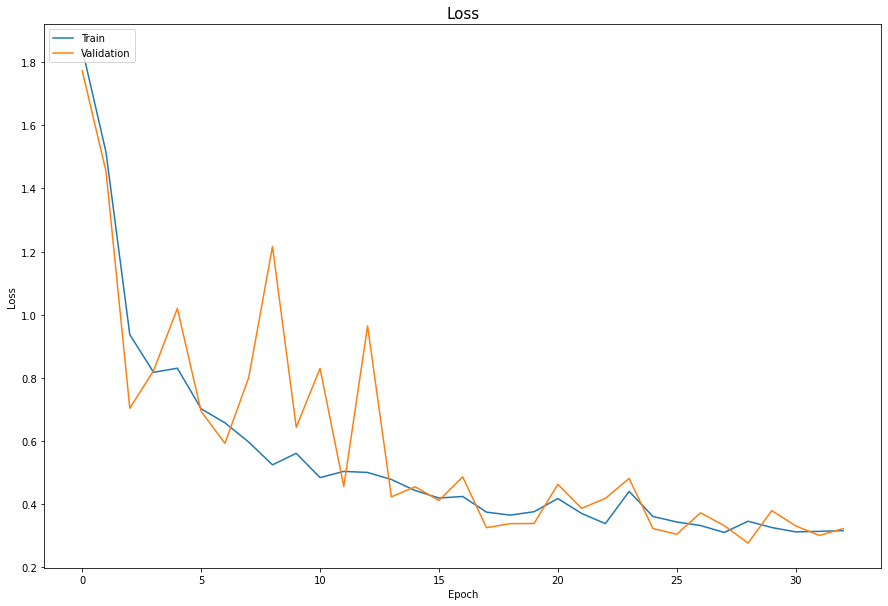

In [48]:
plot_acc_and_loss(train_model_lr)

In [49]:
test_preds = model_lr.predict(X_test)

33/33 [==============================] - 0s 4ms/step


In [50]:
test_preds = np.argmax(test_preds, axis = 1)
test_true = np.argmax(y_test.values, axis = 1)

In [51]:
test_accuracy_report(model_lr)

33/33 [==============================] - 0s 3ms/step
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.50      0.85      0.63        95
              ant problems       0.90      0.99      0.94        91
  few varrao, hive beetles       0.54      0.34      0.41       116
                   healthy       0.99      0.93      0.96       677
         hive being robbed       0.80      0.90      0.85        50
             missing queen       0.60      1.00      0.75         6

                  accuracy                           0.86      1035
                 macro avg       0.72      0.83      0.76      1035
              weighted avg       0.88      0.86      0.86      1035

Loss function: 0.31342360377311707, accuracy: 0.8608695864677429


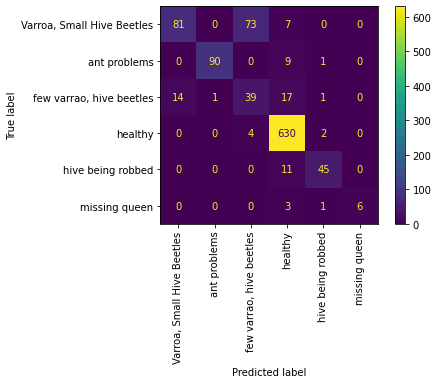

In [52]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical');

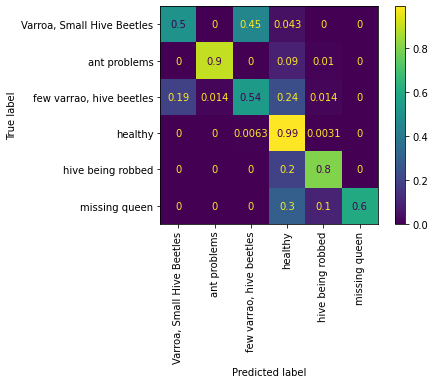

In [53]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical',
                                        normalize = 'true');

This model achieved an accuracy of 86.09%, greatly improved from the baseline accuracy of 65.43%.

In [54]:
# Uncomment to over-write models
# model1.save('/content/drive/MyDrive/colab_notebooks/models/model_1_health_bal')
# model_drop.save('/content/drive/MyDrive/colab_notebooks/models/model_drop_health_bal')
# model_lr.save('/content/drive/MyDrive/colab_notebooks/models/model_lr_health_bal')